In the following code, I would like to summarize the core of two of my research projects, both in the theme of network science
In the first section, I analyze the network of public transportation in Budapest using GTFS data
In the second section, I perform the 15-minute analysis, which aims to provide an upper bound for decision-makers on how large an area it can cover from one stop

Importing the packages

In [54]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform, pdist
from io import StringIO
from geopy.distance import geodesic
import matplotlib.cm as cm 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from math import radians, sin, cos, sqrt, atan2
from networkx.algorithms.community import greedy_modularity_communities
import pickle
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import geopandas as gpd
import networkx as nx
import seaborn as sns
import numpy as np

In [2]:
df_common = pd.DataFrame()
for i in range(1, 8): 
    file_path = f"/mnt/common-ssd/mizsakma/tkom-data/gtfs_puskas/gtfs/gtfs_whole_week/gtfs ({i})/stops.txt"
    with open(file_path, 'r') as file:
        file_contents = file.read()
    df = pd.read_csv(StringIO(file_contents), sep=",")
    df_common = pd.concat([df_common, df], ignore_index=True)
    df_common = df_common.drop_duplicates()

# Here, I create one big DataFrame containing all unique stops occurring across any of the days

In [3]:
myprojection_latlong_2 = 4326
stops = gpd.GeoDataFrame(geometry = gpd.points_from_xy(df_common["stop_lon"], df_common["stop_lat"]), crs = myprojection_latlong_2)

def calculate_geodesic_distance(point1, point2):
    return geodesic((point1.y, point1.x), (point2.y, point2.x)).meters

stops = gpd.GeoDataFrame(geometry=stops["geometry"])
stops.crs = myprojection_latlong_2
stops = stops.to_crs(myprojection_latlong_2)

num_points = len(stops)
geodesic_distance_matrix = np.zeros((num_points, num_points))

# calculating geodesic distances between pairs of points represented by longitude and latitude coordinates.
#The distance matrix initialized here will be populated with actual distance values in subsequent step

In [4]:
try:
    puskas_matrix = np.load("/mnt/common-ssd/mizsakma/tkom-data/gtfs_puskas/gtfs/gtfs_puskas/puskas_week.npy") #loading the distance matrix if exists
    puskas_matrix_condensed = squareform(puskas_matrix)
except FileNotFoundError:
    for i in tqdm(range(num_points)):
        for j in range(num_points):
            if i != j:
                distance = calculate_geodesic_distance(stops.iloc[i].geometry, stops.iloc[j].geometry)
                geodesic_distance_matrix[i, j] = distance
    np.save("puskas_week.npy", geodesic_distance_matrix)

In [5]:
#hierarchical clustering on the distance matrix 

linkage_matrix = linkage(puskas_matrix_condensed, method="complete")
dist_threshold = 150
clusters = fcluster(linkage_matrix, dist_threshold, criterion="distance")
df_common["clust"] = clusters

In [6]:
stop_clusters = df_common.groupby('stop_name')['clust'].unique()
stop_clusters_count = stop_clusters.apply(len)
stop_clusters_count_df = stop_clusters_count.reset_index()
stop_clusters_count_df.columns = ['stop_name', 'num_clusters']

# Determine how many distinct clusters are associated with each stop in the transportation network. It is necessary because accurately creating nodes is essential for a working network

In [7]:
df_common_2 = df_common[df_common['stop_name'].str.endswith(('M', 'H'))]
clust_names_2 = set(df_common_2['stop_name'])
clust_names_2.add('Haller utca / Soroksári út')
clust_names_2 = list(clust_names_2)

#However in the case of metros and and the bigger squares which we would like to consider as stop the 150m treshold is not enough. 
#But luckily we can do it automatically, because in the case of  and hév (literally metro but it has an other name in hungarian) at each stop there is an M or a H.
#For example in the case of Örs Vezér tere M+H the maximum distance between two stops is 500 meters, while both of them is called Örs vezér tere M+H.

In [8]:
for i in clust_names_2:
        filtered_df = df_common[df_common['stop_name'] == i]
        unique_clusters = filtered_df['clust'].unique()
        if len(unique_clusters) >= 2:
            same = unique_clusters[:-1]
            clust_num = unique_clusters[-1]
            df_common.loc[df_common['clust'].isin(same), 'clust'] = clust_num

In [9]:
df_common

,stop_id,stop_name,stop_lat,stop_lon,stop_code,location_type,parent_station,wheelchair_boarding,stop_direction,clust
0,002133,"Örs vezér tere M+H, déli tárolótér",47.500366,19.135700,NaN,NaN,NaN,NaN,NaN,632
1,002138,Kőbánya alsó vasútállomás,47.483139,19.127891,NaN,NaN,NaN,2.0,NaN,430
2,003002,Puskás Ferenc Stadion M,47.500368,19.103406,NaN,NaN,NaN,NaN,NaN,676
3,003103,"Káposztásmegyer, Mogyoródi-patak",47.598778,19.121447,NaN,NaN,NaN,NaN,NaN,1354
4,003105,Bécsi út / Vörösvári út,47.548817,19.029722,NaN,NaN,NaN,2.0,NaN,1214
...,...,...,...,...,...,...,...,...,...,...
5982,F01902,Budafoki elágazás,47.435406,19.035717,NaN,NaN,NaN,2.0,-81.0,1526
5983,F02476,Széll Kálmán tér M,47.507358,19.024496,NaN,NaN,NaN,1.0,-90.0,1706
5984,F02477,Széll Kálmán tér M,47.507232,19.025186,NaN,NaN,NaN,1.0,90.0,1706
5985,F02730,Zugló vasútállomás,47.511720,19.099153,NaN,NaN,NaN,1.0,-128.0,2113


Distance within clusters

In [10]:
def calculate_geodesic_distance(point1, point2):
    latitude1, longitude1 = point1[0], point1[1]
    latitude2, longitude2 = point2[0], point2[1]
    return geodesic((latitude1, longitude1), (latitude2, longitude2)).meters

In [11]:
cluster_distances = []

for cluster_id, group in tqdm(df_common.groupby('clust')):
    coordinates = group[['stop_lat', 'stop_lon']].values  
    pairwise_distances = pdist(coordinates, metric=calculate_geodesic_distance)
    if len(pairwise_distances) > 0:
        distance_matrix = squareform(pairwise_distances)
        max_distance = distance_matrix.max()
        cluster_distances.append((cluster_id, max_distance))
    else:
        cluster_distances.append((cluster_id, 0))
cluster_distances_df = pd.DataFrame(cluster_distances, columns=['clust', 'max_distance'])
df_common = pd.merge(df_common, cluster_distances_df, on = 'clust')

  5%|▍         | 108/2354 [00:00<00:02, 1074.32it/s]

100%|██████████| 2354/2354 [00:03<00:00, 630.97it/s]


In [12]:
df_2 = df_common.sort_values('clust').copy()
df_2 = df_2.drop_duplicates()
df_2['quant'] = df_2.groupby('clust')['clust'].transform('count')
df_2.loc[df_2['location_type'] == 1.0, 'parent_station'] = df_2['stop_id']

df_2_b = df_2[df_2['quant'] > 1].copy()
df_2_a = df_2[df_2['quant'] <= 1].copy()

# df_2_b part
df_2_b = df_2_b.sort_values('clust')

df_2_b['parent_station'] = df_2_b['parent_station'].astype(str)
max_parent_by_clust = df_2_b.groupby('clust')['parent_station'].transform(lambda x: np.where(x != '', x, x.max()))
df_2_b['parent_station'] = max_parent_by_clust

grouped = df_2_b.groupby('clust')
max_parent_by_clust = grouped['parent_station'].transform(lambda x: np.where(x.notna(), x, x.max()))

df_2_b['parent_station'] = np.where(
    (df_2_b['parent_station'] == 'nan') & (df_2_b['quant'] > 1),
    df_2_b.groupby('clust')['stop_id'].transform(lambda x: x.iloc[0]),
    max_parent_by_clust
)

#df_2_a part -> quant with the value of 1, or without value
lonely_stops = (df_2_a['quant'] == 1) & (df_2_a['parent_station'].isna())
df_2_a.loc[lonely_stops, 'parent_station'] = df_2_a.loc[lonely_stops, 'stop_id']

#Unite
df_2 = pd.concat([df_2_a, df_2_b], ignore_index=True)
df_2['parent_station'] = df_2.groupby('clust')['parent_station'].transform('first')
df_2['stop_lon'] = df_2.groupby('parent_station')['stop_lon'].transform('first')
df_2['stop_lat'] = df_2.groupby('parent_station')['stop_lat'].transform('first')
df_2 = df_2.drop_duplicates()
df = df_2.copy()
df['stop_id'] = df['parent_station']
#Here I have to operform some data manipulation in order to be unified parent_sation at every cluster in every single case

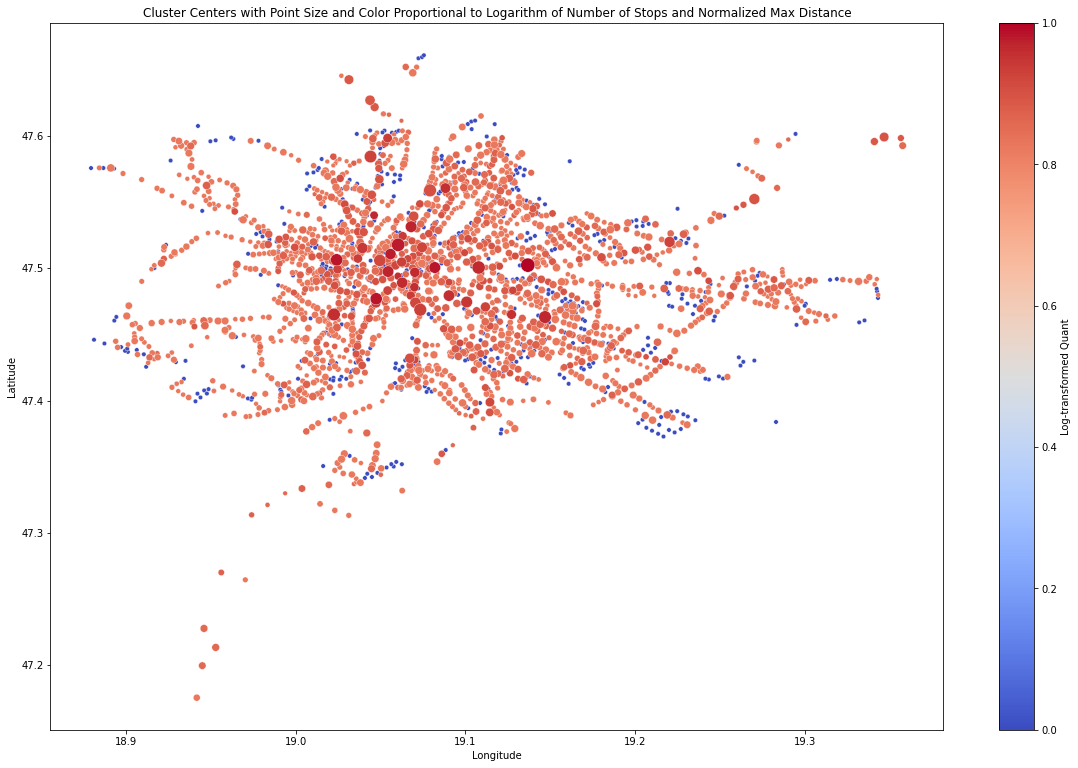

In [13]:
df_2_filtered_log = df_2.copy()
df_2_filtered_log.loc[df_2_filtered_log['max_distance'] == 0, 'max_distance'] = 1
df_2_filtered_log['quant'] = np.log(df_2_filtered_log['quant'] + 1e-10)  

cluster_centers = df_2_filtered_log.groupby('clust').agg({
    'stop_lat': 'mean',
    'stop_lon': 'mean',
    'quant': 'sum',
    'max_distance': 'max'  
}).reset_index()

max_distance_min = cluster_centers['max_distance'].min()
max_distance_max = cluster_centers['max_distance'].max()
cluster_centers['max_distance_normalized'] = (cluster_centers['max_distance'] - max_distance_min) / (max_distance_max - max_distance_min)

cluster_centers = cluster_centers.sort_values(by='max_distance_normalized', ascending=True)

plt.figure(figsize=(20, 13))  
scatter = sns.scatterplot(
    x='stop_lon',
    y='stop_lat',
    size=cluster_centers['max_distance_normalized'], 
    hue=np.log(cluster_centers['quant']), 
    palette='coolwarm', 
    data=cluster_centers,
    sizes=(20, 200),  
    legend=False,
    zorder=2  
)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cluster Centers with Point Size and Color Proportional to Logarithm of Number of Stops and Normalized Max Distance')

sm = cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=cluster_centers['max_distance_normalized'].min(), vmax=cluster_centers['max_distance_normalized'].max()))
sm.set_array([])

cbar = plt.colorbar(sm, label='Log-transformed Quant', ax=scatter)

plt.savefig('cluster_map.png')

plt.show()

## Concept of minimized edges

In [14]:
list_of_netwroks_own_w = []
list_of_stop_time = []
list_of_network_time = []

puskas_list_of_weights = []
list_of_networks_puskas = []

stop_times_dic_for_each_hour = {}

pure_stop_times_next_day = pd.DataFrame()

for days in tqdm(range(1,8)):

    file_path = f"/mnt/common-ssd/mizsakma/tkom-data/gtfs_puskas/gtfs/gtfs_whole_week/gtfs ({days})"
    
    pure_stop_times = pd.read_csv(file_path + "/stop_times.txt", sep=",", dtype={'stop_headsign': 'object'})
    
    routes = pd.read_csv(file_path + "/routes.txt", sep=",")

    trips = pd.read_csv(file_path + "/trips.txt", sep=",", dtype={'route_id': 'object'})

    pure_stop_times = pure_stop_times.merge(df_2[['stop_id', 'clust', 'parent_station', 'stop_name']], on='stop_id', how='left')
    pure_stop_times.loc[pure_stop_times['parent_station'].notna(), 'stop_id'] = pure_stop_times['parent_station']
    pure_stop_times.loc['stop_id'] = pure_stop_times['parent_station']

    routes = routes[['route_id', 'route_type']]
    trips = trips[['route_id', 'trip_id', 'service_id']]  
    trips = pd.merge(trips, routes, on='route_id', how='right')
    pure_stop_times = pure_stop_times.merge(trips[['trip_id', 'route_id', 'route_type', 'service_id']], on='trip_id', how='left')

    pure_stop_times['stop_id_to'] = pure_stop_times.groupby((['trip_id', 'service_id', 'route_id', 'route_type']))['stop_id'].shift(-1)
    pure_stop_times['arrival_time_stop_to'] = pure_stop_times.groupby(['trip_id', 'service_id', 'route_id', 'route_type'])['arrival_time'].shift(-1)
    pure_stop_times['distance_travaled'] = pure_stop_times.groupby(['trip_id', 'service_id', 'route_id', 'route_type'])['shape_dist_traveled'].shift(-1)

    #deleting the terminals and loops
    pure_stop_times = pure_stop_times[pure_stop_times['arrival_time_stop_to'].notna()]
    pure_stop_times = pure_stop_times[pure_stop_times['stop_id'] != pure_stop_times['stop_id_to']]

    pure_stop_times['arrival_hour'] = pure_stop_times['arrival_time_stop_to'].apply(lambda x: int(x.split(':')[0]))
    pure_stop_times['arrival_minute'] = pure_stop_times['arrival_time_stop_to'].apply(lambda x: int(x.split(':')[1]))
    pure_stop_times['arrival_second'] = pure_stop_times['arrival_time_stop_to'].apply(lambda x: int(x.split(':')[2]))

    pure_stop_times['departure_hour'] = pure_stop_times['departure_time'].apply(lambda x: int(x.split(':')[0]))
    pure_stop_times['departure_minute'] = pure_stop_times['departure_time'].apply(lambda x: int(x.split(':')[1]))
    pure_stop_times['departure_second'] = pure_stop_times['departure_time'].apply(lambda x: int(x.split(':')[2]))
    
    pure_stop_times['arrival_time'] = pd.to_datetime({
        'year': 2020,  
        'month': 9,   
        'day': 20 + days,      
        'hour': pure_stop_times['arrival_hour'],
        'minute': pure_stop_times['arrival_minute'],
        'second': pure_stop_times['arrival_second'] })

    pure_stop_times['departure_time'] = pd.to_datetime({
        'year':2020,
        'month':9,
        'day': 20 + days,
        'hour':pure_stop_times['departure_hour'],
        'minute':pure_stop_times['departure_minute'],
        'second':pure_stop_times['departure_second']
    })

    pure_stop_times = pd.concat([pure_stop_times, pure_stop_times_next_day], ignore_index=True)
    pure_stop_times_next_day = pure_stop_times[pure_stop_times['departure_hour'] >= 24].copy()
    pure_stop_times_next_day['departure_hour'] = pure_stop_times_next_day['departure_hour'] % 24
    pure_stop_times = pure_stop_times[pure_stop_times['departure_hour'] < 24]
    
    pure_stop_times['edge_frequency'] = pure_stop_times.groupby(['stop_id', 'stop_id_to','departure_hour', 'trip_id']).transform('size')
    pure_stop_times['travel_duration'] = pure_stop_times['arrival_time'] - pure_stop_times['departure_time']
    pure_stop_times['travel_duration'] = pure_stop_times['travel_duration'].dt.total_seconds().astype(int)
    pure_stop_times['distance_travaled'] = pure_stop_times['distance_travaled'] - pure_stop_times['shape_dist_traveled']

    pure_stop_times = pure_stop_times[['trip_id', 'stop_id', 'stop_id_to','stop_sequence', 'route_id', 'route_type', 'travel_duration', 'distance_travaled', 'departure_hour', 'edge_frequency', 'departure_time', 'arrival_time']]
    
    pure_stop_times['weight_own'] = pure_stop_times['edge_frequency'] * (pure_stop_times['travel_duration'] + 1 / (pure_stop_times['distance_travaled'] + 1))
    pure_stop_times['weight_freq'] = pure_stop_times['edge_frequency']
    pure_stop_times['weight_time'] = pure_stop_times.groupby(['stop_id', 'stop_id_to', 'departure_hour'])['travel_duration'].transform('min')
    pure_stop_times['weight_dis'] = pure_stop_times.groupby(['stop_id', 'stop_id_to', 'departure_hour'])['distance_travaled'].transform('mean')

    #chacking the area around puskás

    stop_id_to_list = pure_stop_times[pure_stop_times['stop_id'] == 'F01319']['stop_id_to'].tolist()
    puskas_trip = pure_stop_times[pure_stop_times['stop_id'].isin(stop_id_to_list)]['trip_id'].tolist()
    puskas_stops = pure_stop_times[pure_stop_times['trip_id'].isin(puskas_trip)]

    list_of_stop_time.append(pure_stop_times)
    puskas_list_of_weights.append(puskas_stops)
        
    for hour in range(24):
        pure_stop_times_network = pure_stop_times[pure_stop_times['departure_hour'] == hour]

        name = f"{days}_day_{hour}_hour_df"
        stop_times_dic_for_each_hour[name] = pure_stop_times_network
        
        network_own = nx.from_pandas_edgelist(
            pure_stop_times_network,
            source = 'stop_id',
            target ='stop_id_to',
            edge_attr = ['weight_own'],
            create_using = nx.DiGraph()
        )
        list_of_netwroks_own_w.append(network_own)

        network_time = nx.from_pandas_edgelist(
            pure_stop_times_network,
            source = 'stop_id',
            target = 'stop_id_to',
            edge_attr = ['weight_time'],
            create_using = nx.DiGraph()
        )
        list_of_network_time.append(network_time)

        puskas_stops_hour = puskas_stops[puskas_stops['departure_hour'] == hour]
        network_puskas = nx.from_pandas_edgelist(
            puskas_stops_hour,
            source = 'stop_id',
            target = 'stop_id_to',
            edge_attr = ['weight_time'],
            create_using = nx.DiGraph()
        )
        list_of_networks_puskas.append(network_puskas)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [10:50<00:00, 92.92s/it]


In [15]:
#min_stop_sequence = pure_stop_times.groupby('trip_id')['stop_sequence'].min().reset_index()
#pure_stop_times = pure_stop_times.merge(min_stop_sequence, on='trip_id', suffixes=('', '_min'))
#pure_stop_times = pure_stop_times[pure_stop_times['stop_sequence'] == pure_stop_times['stop_sequence_min']]
#pure_stop_times.drop(columns=['stop_sequence_min'], inplace=True)

Trying to create a new fully connected network, to know where shall I cluster more

Calculating the results

In [16]:
#with open("list_of_network_time.pkl", "wb") as f:
#    pickle.dump(list_of_network_time, f)
#
#with open("list_of_netwroks_own_w.pkl", "wb") as f:
#    pickle.dump(list_of_netwroks_own_w, f)

In [17]:
def compute_metrics(network, day, hour):
    num_of_edges = nx.number_of_edges(network)
    num_of_nodes = nx.number_of_nodes(network)
    avg_clus = nx.average_clustering(network, weight='weight')
    betweenness_centrality = nx.betweenness_centrality(network, weight='weight')
    mean_betweenness = sum(betweenness_centrality.values()) / (len(betweenness_centrality))
    density_value = nx.density(network)
    beta_index_value = num_of_edges / num_of_nodes

    return {
        'num_of_edges': num_of_edges,
        'num_of_nodes': num_of_nodes,
        'avg_clustering': avg_clus,
        'mean_betweenness': mean_betweenness,
        'density': density_value,
        'beta_index': beta_index_value
        }

days = [day for day in range(1, 8) for _ in range(24)]
hours = [hour for _ in range(7) for hour in range(24)]

In [18]:
try:
    df_results_own = pd.read_csv("list_of_netwroks_own_w_3_min.csv")
except FileNotFoundError:

    metrics_results = []
    with ProcessPoolExecutor() as executor:
        results = list(tqdm(executor.map(compute_metrics, list_of_netwroks_own_w, days, hours), total=len(list_of_netwroks_own_w)))

    metrics_results.extend(results)
    df_results_own = pd.DataFrame(metrics_results)
    df_results_own.to_csv("list_of_netwroks_own_w_3_min.csv", index=False)

In [19]:
try:
    df_results_time = pd.read_csv("list_of_netwroks_time_3_min.csv")
except FileNotFoundError:

    metrics_results_2 = []
    with ProcessPoolExecutor() as executor:
        results_2 = list(tqdm(executor.map(compute_metrics, list_of_network_time, days, hours), total=len(list_of_network_time)))

    metrics_results_2.extend(results_2)
    df_results_time = pd.DataFrame(metrics_results_2)
    df_results_time.to_csv("list_of_netwroks_time_3_min.csv", index=False)

In [20]:
list_of_networks_puskas = [network for network in list_of_networks_puskas if nx.number_of_edges(network) != 0]

try:
    df_results_time_puskas = pd.read_csv("list_of_netwroks_time_puskas_3_min.csv")
except FileNotFoundError:

    metrics_results_3 = []
    with ProcessPoolExecutor() as executor:
        results_3 = list(tqdm(executor.map(compute_metrics, list_of_networks_puskas, days, hours), total=len(list_of_networks_puskas)))

    metrics_results_3.extend(results_3)
    df_results_time_puskas = pd.DataFrame(metrics_results_3)
    df_results_time_puskas.to_csv("list_of_netwroks_time_puskas_3_min.csv", index=False)

In [21]:
df_results_own['day'] = days
df_results_time['day'] = days

df_results_own['hour'] = hours
df_results_time['hour'] = hours

df_results_time_puskas['day'] = days[3:]
df_results_time_puskas['hour'] = hours[3:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


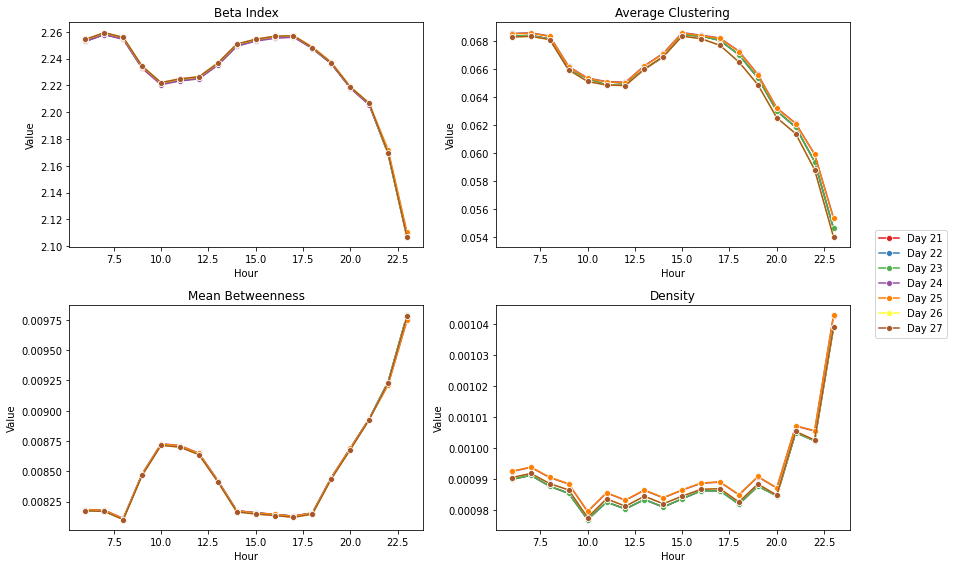

In [22]:
columns_to_plot = ['global_efficiency', 'avg_clustering', 'mean_betweenness', 'density', 'beta_index']
df_final = df_results_own[df_results_own['hour'] > 5]

unique_days = df_final['day'].unique()

sns.set_palette("Set1", n_colors=len(unique_days))  

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for day in unique_days:
    df_day = df_final[df_final['day'] == day]

    sns.lineplot(x='hour', y='beta_index', data=df_day, marker='o', linestyle='-', ax=axes[0, 0], label=f'Day {day + 20}')

    sns.lineplot(x='hour', y='avg_clustering', data=df_day, marker='o', linestyle='-', ax=axes[0, 1])

    sns.lineplot(x='hour', y='mean_betweenness', data=df_day, marker='o', linestyle='-', ax=axes[1, 0])

    sns.lineplot(x='hour', y='density', data=df_day, marker='o', linestyle='-', ax=axes[1, 1])

axes[0, 0].set_title('Beta Index')
axes[0, 1].set_title('Average Clustering')
axes[1, 0].set_title('Mean Betweenness')
axes[1, 1].set_title('Density')

for ax in axes.flat:
    ax.set_xlabel('Hour')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right')
    ax.legend().remove()  

    
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5), borderaxespad=0.)

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


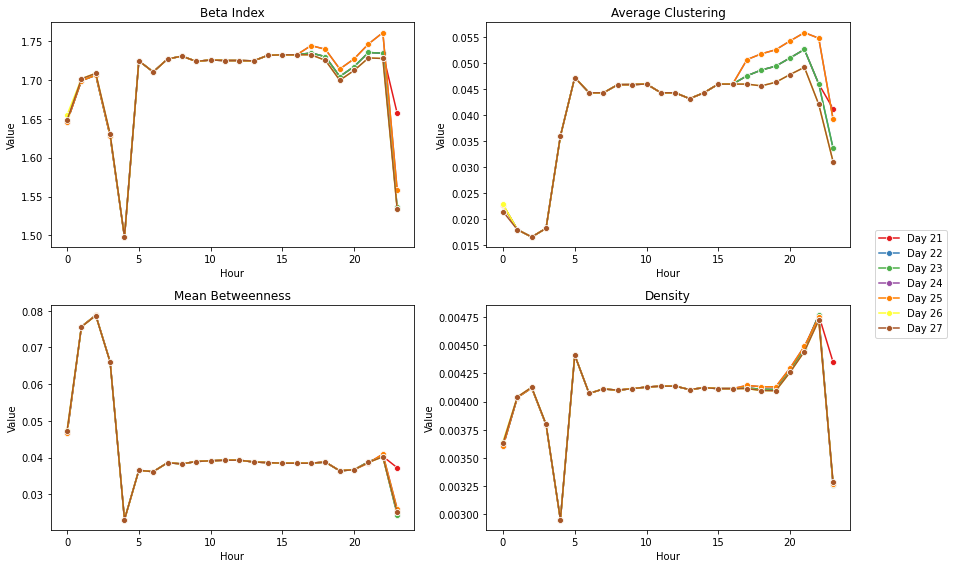

In [23]:
columns_to_plot = ['global_efficiency', 'avg_clustering', 'mean_betweenness', 'density', 'beta_index']
df_final = df_results_time_puskas[5:]

unique_days = df_final['day'].unique()

sns.set_palette("Set1", n_colors=len(unique_days))  

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for day in unique_days:
    df_day = df_final[df_final['day'] == day]

    sns.lineplot(x='hour', y='beta_index', data=df_day, marker='o', linestyle='-', ax=axes[0, 0], label=f'Day {day + 20}')

    sns.lineplot(x='hour', y='avg_clustering', data=df_day, marker='o', linestyle='-', ax=axes[0, 1])

    sns.lineplot(x='hour', y='mean_betweenness', data=df_day, marker='o', linestyle='-', ax=axes[1, 0])

    sns.lineplot(x='hour', y='density', data=df_day, marker='o', linestyle='-', ax=axes[1, 1])

axes[0, 0].set_title('Beta Index')
axes[0, 1].set_title('Average Clustering')
axes[1, 0].set_title('Mean Betweenness')
axes[1, 1].set_title('Density')

for ax in axes.flat:
    ax.set_xlabel('Hour')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right')
    ax.legend().remove()  

    
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5), borderaxespad=0.)

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


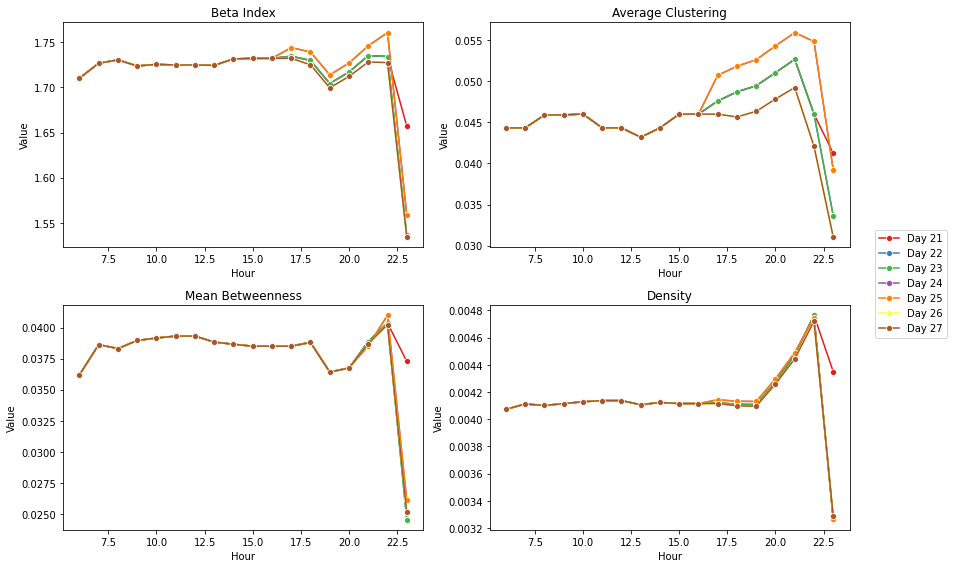

In [24]:
columns_to_plot = ['global_efficiency', 'avg_clustering', 'mean_betweenness', 'density', 'beta_index']
df_final = df_results_time_puskas[df_results_time_puskas['hour'] > 5]

unique_days = df_final['day'].unique()

sns.set_palette("Set1", n_colors=len(unique_days))  

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for day in unique_days:
    df_day = df_final[df_final['day'] == day]

    sns.lineplot(x='hour', y='beta_index', data=df_day, marker='o', linestyle='-', ax=axes[0, 0], label=f'Day {day + 20}')

    sns.lineplot(x='hour', y='avg_clustering', data=df_day, marker='o', linestyle='-', ax=axes[0, 1])

    sns.lineplot(x='hour', y='mean_betweenness', data=df_day, marker='o', linestyle='-', ax=axes[1, 0])

    sns.lineplot(x='hour', y='density', data=df_day, marker='o', linestyle='-', ax=axes[1, 1])

axes[0, 0].set_title('Beta Index')
axes[0, 1].set_title('Average Clustering')
axes[1, 0].set_title('Mean Betweenness')
axes[1, 1].set_title('Density')

for ax in axes.flat:
    ax.set_xlabel('Hour')
    ax.set_ylabel('Value')
    ax.legend(loc='upper right')
    ax.legend().remove()  

    
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5), borderaxespad=0.)

plt.tight_layout()
plt.show()

In [25]:
weights = pd.concat(list_of_stop_time, axis=0, ignore_index=True)
weights['day'] = weights['departure_time'].dt.day
weights = weights[['stop_id', 'stop_id_to', 'departure_hour', 'weight_own', 'weight_freq', 'weight_dis', 'weight_time', 'day']]
# Perform groupby and aggregation, then reset the index
weights = weights.drop_duplicates()
weights = weights.groupby(['departure_hour', 'day']).agg({
    'weight_own': 'sum',
    'weight_freq': 'sum',
    'weight_time': 'sum',
    'weight_dis': 'sum'
}).reset_index()

weights = weights.sort_values(by=(['day', 'departure_hour']))[2:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


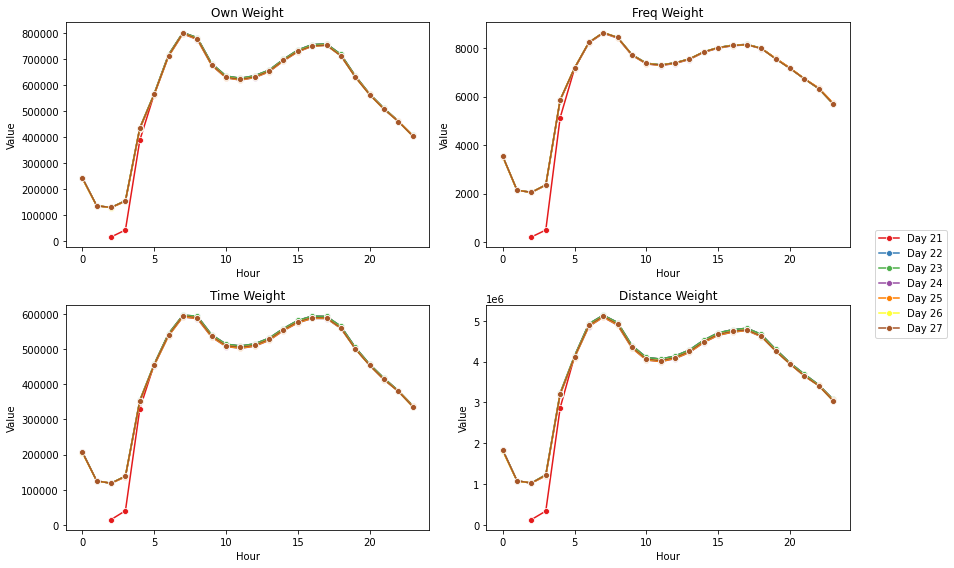

In [26]:
columns_to_plot = ['weight_own', 'weight_freq', 'weight_time', 'weight_dis']
df_final = weights  
unique_days = df_final['day'].unique()
sns.set_palette("Set1", n_colors=len(unique_days))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for day in unique_days:
    df_day = df_final[df_final['day'] == day]

    sns.lineplot(x='departure_hour', y='weight_own', data=df_day, marker='o', linestyle='-', ax=axes[0, 0], label=f'Day {day}')
    sns.lineplot(x='departure_hour', y='weight_freq', data=df_day, marker='o', linestyle='-', ax=axes[0, 1])
    sns.lineplot(x='departure_hour', y='weight_time', data=df_day, marker='o', linestyle='-', ax=axes[1, 0])
    sns.lineplot(x='departure_hour', y='weight_dis', data=df_day, marker='o', linestyle='-', ax=axes[1, 1])

axes[0, 0].set_title('Own Weight')
axes[0, 1].set_title('Freq Weight')
axes[1, 0].set_title('Time Weight')
axes[1, 1].set_title('Distance Weight')

for ax in axes.flat:
    ax.set_xlabel('Hour')
    ax.set_ylabel('Value')
    ax.legend().remove()  

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5), borderaxespad=0.)

plt.tight_layout()
plt.savefig('puskas_week_weights.png', bbox_inches='tight')
plt.show()

In [27]:
weights = pd.concat(puskas_list_of_weights, axis=0, ignore_index=True)
weights['day'] = weights['departure_time'].dt.day
weights = weights[['stop_id', 'stop_id_to', 'departure_hour', 'weight_own', 'weight_freq', 'weight_dis', 'weight_time', 'day']]
# Perform groupby and aggregation, then reset the index
weights = weights.drop_duplicates()
weights = weights.groupby(['departure_hour', 'day']).agg({
    'weight_own': 'sum',
    'weight_freq': 'sum',
    'weight_time': 'sum',
    'weight_dis': 'sum'
}).reset_index()

weights = weights.sort_values(by=(['day', 'departure_hour']))[2:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


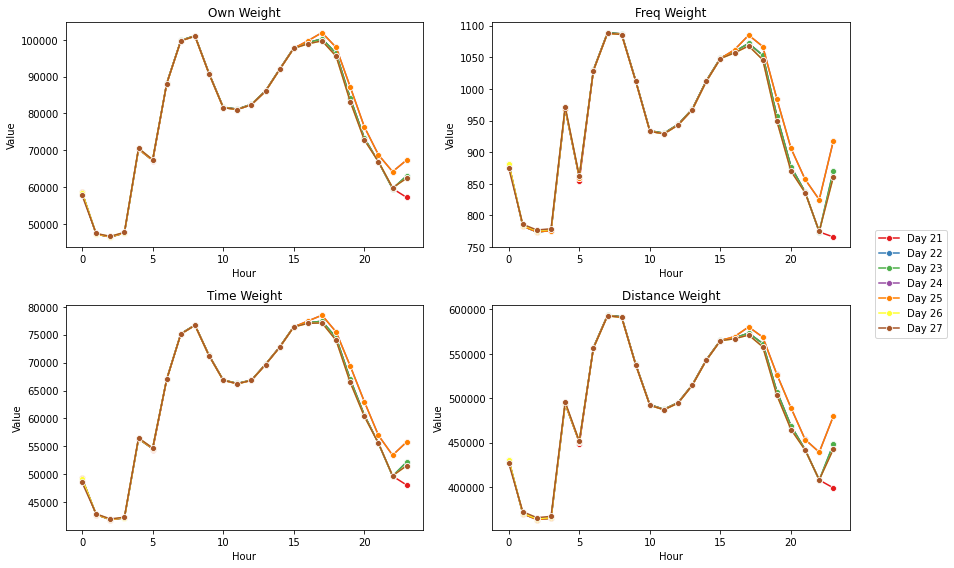

In [28]:
columns_to_plot = ['weight_own', 'weight_freq', 'weight_time', 'weight_dis']
df_final = weights  
unique_days = df_final['day'].unique()
sns.set_palette("Set1", n_colors=len(unique_days))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for day in unique_days:
    df_day = df_final[df_final['day'] == day]

    sns.lineplot(x='departure_hour', y='weight_own', data=df_day, marker='o', linestyle='-', ax=axes[0, 0], label=f'Day {day}')
    sns.lineplot(x='departure_hour', y='weight_freq', data=df_day, marker='o', linestyle='-', ax=axes[0, 1])
    sns.lineplot(x='departure_hour', y='weight_time', data=df_day, marker='o', linestyle='-', ax=axes[1, 0])
    sns.lineplot(x='departure_hour', y='weight_dis', data=df_day, marker='o', linestyle='-', ax=axes[1, 1])

axes[0, 0].set_title('Own Weight')
axes[0, 1].set_title('Freq Weight')
axes[1, 0].set_title('Time Weight')
axes[1, 1].set_title('Distance Weight')

for ax in axes.flat:
    ax.set_xlabel('Hour')
    ax.set_ylabel('Value')
    ax.legend().remove()  

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5), borderaxespad=0.)

plt.tight_layout()
plt.savefig('puskas_week_weights.png', bbox_inches='tight')
plt.show()

Concept of 15 min city - public transportation using DFS approach

If changing a vehicle counts

In [37]:
def dfs_paths_with_changes(network, df, initial_node, current_path=None, current_weight=0, max_weight=900, node_results=None):
    if current_path is None:
        current_path = [initial_node]
        if node_results is None:
            node_results = set()
        node_results.add(initial_node)

    if current_weight <= max_weight:
        has_neighbors = False

        for neighbor in network.neighbors(initial_node):
            edge_weight = network[initial_node][neighbor].get('weight_time', 30)
            neighbor_trip_ids = df.loc[df['stop_id'] == neighbor, 'trip_id'].tolist()

            if neighbor not in current_path:
                new_weight = current_weight + edge_weight

                current_trip_ids = df.loc[df['stop_id'] == initial_node, 'trip_id'].tolist()
                if neighbor_trip_ids and any(trip_id != current_trip_ids for trip_id in neighbor_trip_ids):
                
                    new_weight += 120

                if new_weight <= max_weight:
                    has_neighbors = True
                    yield from dfs_paths_with_changes(network, df, neighbor, current_path + [neighbor], new_weight, max_weight, node_results)
                else:
                    node_results.add(neighbor)

        if not has_neighbors:
            yield current_path, current_weight
            
    return list(node_results)

In [38]:
max_index = df_results_own[df_results_own['day'] == 4]['num_of_edges'].idxmax()
max_network = list_of_network_time[max_index]

kalvin_stop = df[df['stop_name'] == 'Kálvin tér M']['stop_id'].iloc[0]
df_day = int(df_results_time.loc[max_index]['day'])
df_hour = int(df_results_time.loc[max_index]['hour'])
dataframe = stop_times_dic_for_each_hour[f"{df_day}_day_{df_hour}_hour_df"]

In [39]:
edge_list = []

kalvin = dfs_paths_with_changes(max_network, dataframe, kalvin_stop)
for path, weight in kalvin:
    for i in range(len(path) - 1):
        source_node = path[i]
        target_node = path[i + 1]
        edge_list.append((source_node, target_node))
edge_list = set(edge_list)

In [40]:
node_list = []

for edge in edge_list:
    source_node, target_node = edge
    node_list.extend([source_node, target_node])

unique_nodes = set(node_list)
kalvin_nodes = pd.merge(pd.DataFrame(list(unique_nodes), columns=['stop_id']), df, on='stop_id', how='left')
kalvin = kalvin_nodes[['stop_id', 'stop_lat', 'stop_lon']].drop_duplicates()

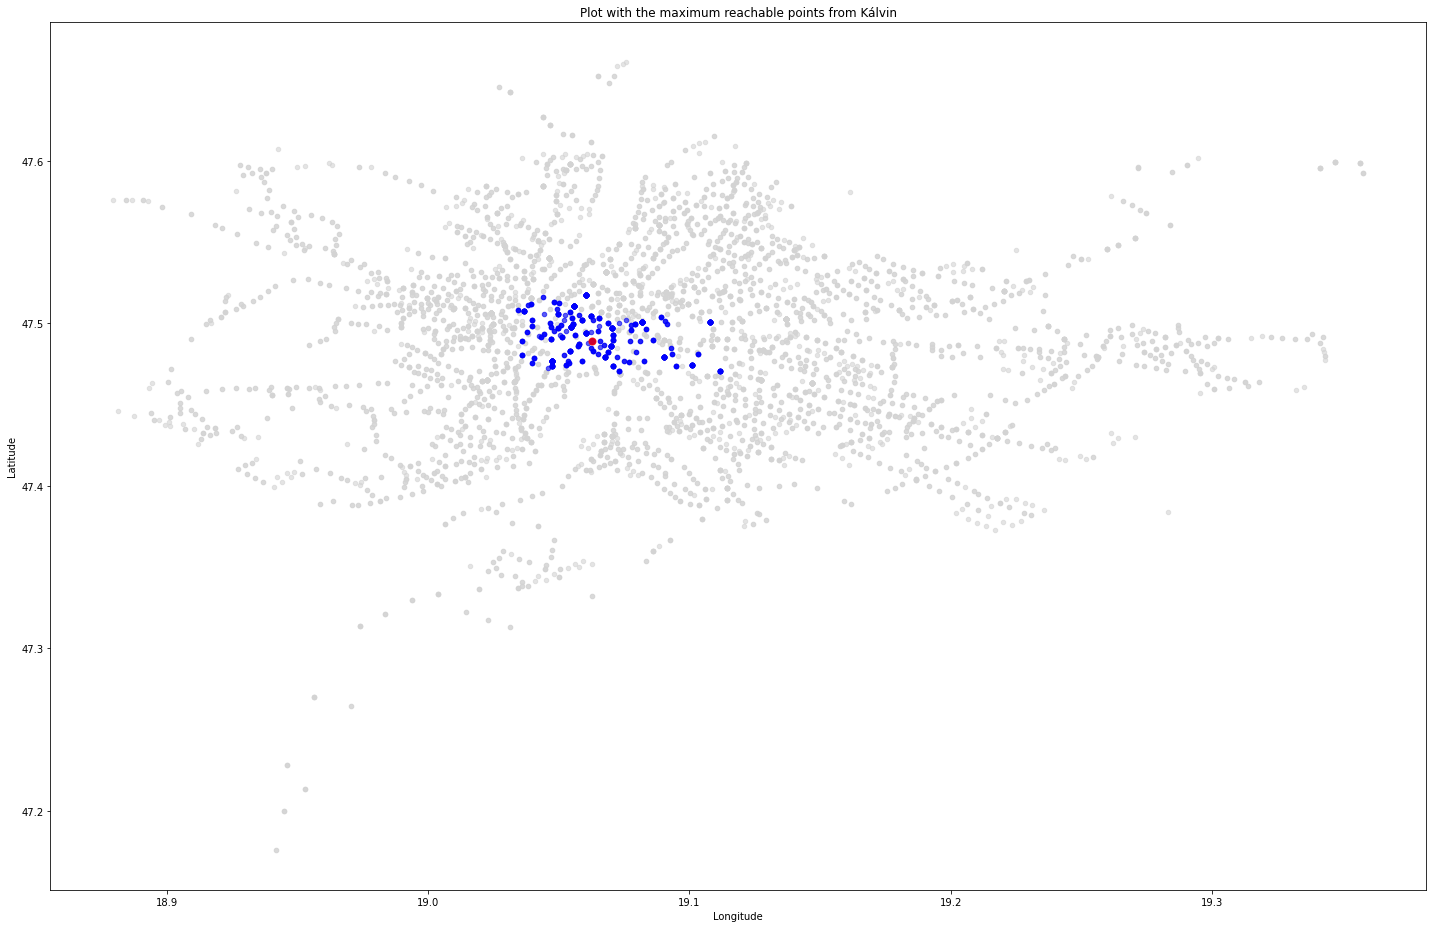

In [42]:
lon = kalvin_nodes['stop_lon']
lat = kalvin_nodes['stop_lat']


plt.figure(figsize=(20, 13))
plt.scatter(df['stop_lon'], df['stop_lat'], c='lightgray', s=20, alpha=0.6)  
plt.scatter(lon, lat, c='blue', s=20, alpha=0.6)

highlight_lon = 19.06284
highlight_lat = 47.489173
plt.scatter(highlight_lon, highlight_lat, c='red', s=50, alpha=0.8)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot with the maximum reachable points from Kálvin')
plt.grid(False) 
plt.tight_layout() 
plt.show()

In [43]:
edge_list = []

max_index = df_results_own[df_results_own['day'] == 4]['num_of_edges'].idxmax()
max_network = list_of_network_time[max_index]

örs_stop = df[df['stop_name'] == 'Örs vezér tere M+H']['stop_id'].iloc[0]
df_day = int(df_results_own.loc[max_index]['day'])
df_hour = int(df_results_own.loc[max_index]['hour'])
dataframe = stop_times_dic_for_each_hour[f"{df_day}_day_{df_hour}_hour_df"]

örs = dfs_paths_with_changes(max_network, dataframe, örs_stop)
for path, weight in örs:
    for i in range(len(path) - 1):
        source_node = path[i]
        target_node = path[i + 1]
        edge_list.append((source_node, target_node))
edge_list = set(edge_list)

node_list = []

for edge in edge_list:
    source_node, target_node = edge
    node_list.extend([source_node, target_node])

unique_nodes = set(node_list)
örs_nodes = pd.merge(pd.DataFrame(list(unique_nodes), columns=['stop_id']), df, on='stop_id', how='left')
örs = örs_nodes[['stop_id', 'stop_lat', 'stop_lon']].drop_duplicates()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


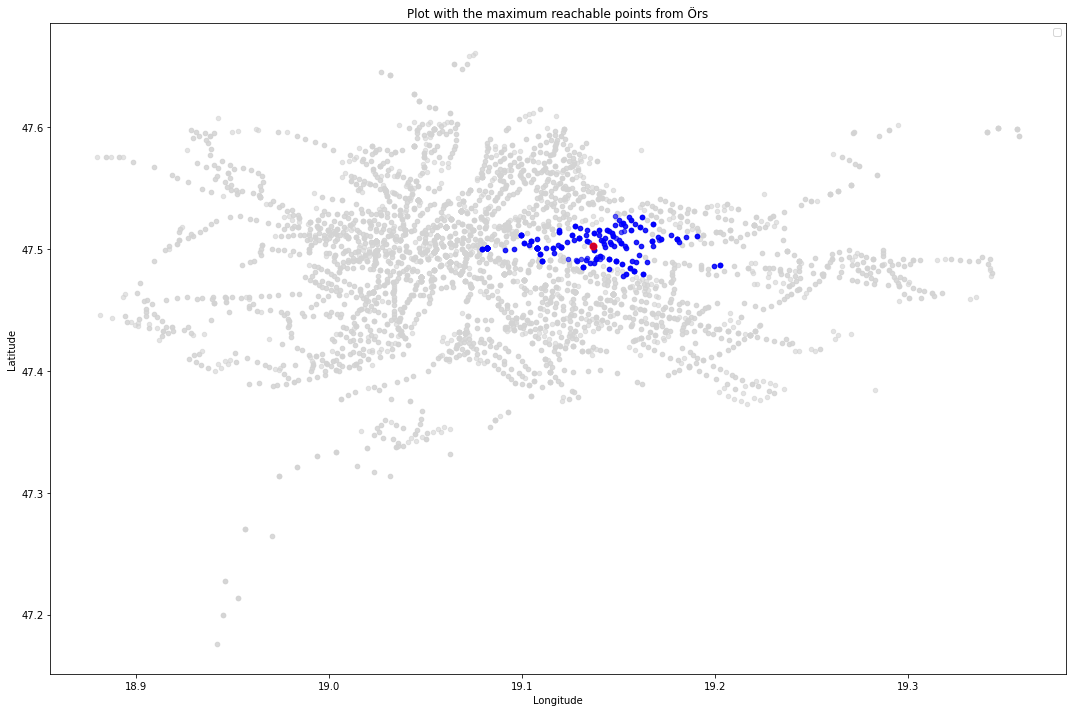

In [44]:
lon = örs_nodes['stop_lon']
lat = örs_nodes['stop_lat']

plt.figure(figsize=(15, 10))

plt.scatter(df['stop_lon'], df['stop_lat'], c='lightgray', s=20, alpha=0.6)  
plt.scatter(lon, lat, c='blue', s=20, alpha=0.6)

highlight_lon = 19.136843
highlight_lat = 47.502448
plt.scatter(highlight_lon, highlight_lat, c='red', s=50, alpha=0.8)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot with the maximum reachable points from Örs')
plt.grid(False) 
plt.legend()
plt.tight_layout() 
plt.show()